In [1]:
!pip3 install pygame


--- Training Tabular Agent ---
MAZE RUNNER - TABULAR Q-LEARNING
Episodes: 500 | Visualization: Every 50 episode(s)
Ep 50/500 | Reward: -307.19 | Steps: 126.1 | ε: 0.778
Ep 100/500 | Reward: -87.61 | Steps: 59.8 | ε: 0.606
Ep 150/500 | Reward: -18.17 | Steps: 50.4 | ε: 0.471
Ep 200/500 | Reward: 34.25 | Steps: 35.4 | ε: 0.367
Ep 250/500 | Reward: 70.95 | Steps: 27.3 | ε: 0.286
Ep 300/500 | Reward: 86.62 | Steps: 24.0 | ε: 0.222
Ep 350/500 | Reward: 86.12 | Steps: 23.0 | ε: 0.173
Ep 400/500 | Reward: 88.62 | Steps: 21.4 | ε: 0.135
Ep 450/500 | Reward: 89.73 | Steps: 20.3 | ε: 0.105
Ep 500/500 | Reward: 94.11 | Steps: 20.3 | ε: 0.082
TRAINING COMPLETED!

--- Training Linear Function Approx Agent ---
MAZE RUNNER - LINEAR FA Q-LEARNING
Episodes: 500 | Visualization: Every 50 episode(s)
Ep 50/500 | Reward: -386.55 | Steps: 186.3 | ε: 0.778
Ep 100/500 | Reward: -260.37 | Steps: 148.0 | ε: 0.606
Ep 150/500 | Reward: -39.29 | Steps: 56.1 | ε: 0.471
Ep 200/500 | Reward: 25.30 | Steps: 41.6 | ε:

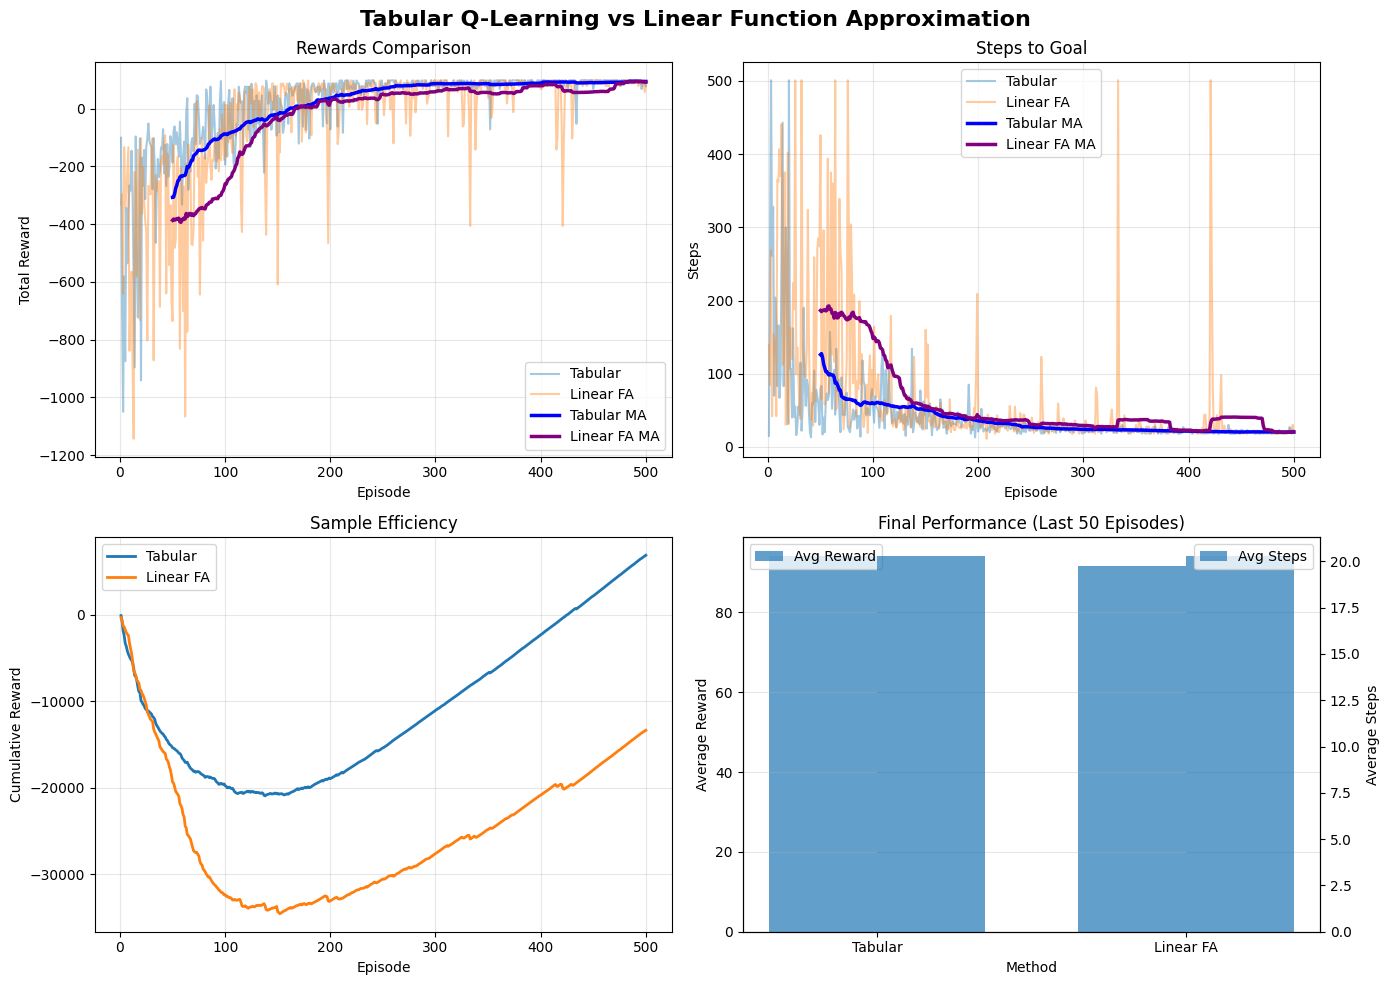

✓ Saved: learned_q_values_comparison.png


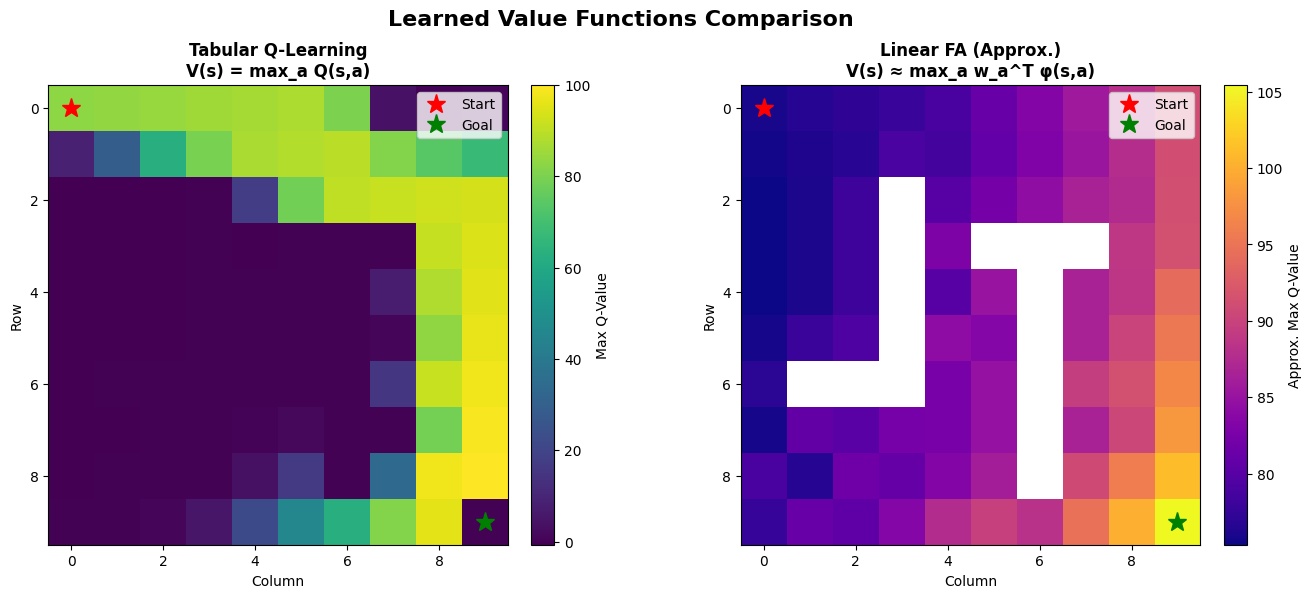


--- Deterministic Evaluation ---
Tabular:   Success=True | Steps=18 | Reward=98.30
LinearFA:  Success=True | Steps=18 | Reward=98.30

Saved: tabular_q_table.npy, linear_fa_weights.npy


In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import pygame
from collections import deque
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

# ============================================
# MDP ENVIRONMENT 
# ============================================
class MazeEnv(gym.Env):
    metadata = {'render_modes': ['human', 'rgb_array']}
    
    def __init__(self, maze_size=10, render_mode=None):
        super().__init__()
        self.size = maze_size
        self.render_mode = render_mode
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(self.size * self.size)
        self.actions = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
        self.maze = self._create_maze()
        self.start_pos = (0, 0)
        self.goal_pos = (self.size - 1, self.size - 1)
        self.agent_pos = self.start_pos
        self.cell_size = 60
        
    def _create_maze(self):
        maze = np.zeros((self.size, self.size), dtype=int)
        if self.size >= 10:
            maze[2:7, 3] = 1
            maze[4:9, 6] = 1
            maze[3, 5:8] = 1
            maze[6, 1:4] = 1
            maze[4, 4] = 2
            maze[7, 7] = 2
            maze[8, 1] = 2
        maze[0, 0] = 0
        maze[self.size-1, self.size-1] = 0
        return maze
    
    def _pos_to_state(self, pos):
        return pos[0] * self.size + pos[1]
    
    def _state_to_pos(self, state):
        return (state // self.size, state % self.size)
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agent_pos = self.start_pos
        return self._pos_to_state(self.agent_pos), {}
    
    def step(self, action):
        move = self.actions[action]
        new_pos = (self.agent_pos[0] + move[0], self.agent_pos[1] + move[1])
        terminated = False
        
        if (new_pos[0] < 0 or new_pos[0] >= self.size or
            new_pos[1] < 0 or new_pos[1] >= self.size):
            reward = -10
            new_pos = self.agent_pos
        elif self.maze[new_pos] == 1:
            reward = -10
            new_pos = self.agent_pos
        elif self.maze[new_pos] == 2:
            reward = -50
            self.agent_pos = new_pos
            terminated = True
        elif new_pos == self.goal_pos:
            reward = 100
            self.agent_pos = new_pos
            terminated = True
        else:
            reward = -0.1
            self.agent_pos = new_pos
        
        terminated = terminated or (self.agent_pos == self.goal_pos)
        return self._pos_to_state(self.agent_pos), reward, terminated, False, {"fell_in_trap": self.maze[new_pos] == 2 if new_pos != self.agent_pos else False}


# ============================================
# TABULAR Q-LEARNING
# ============================================
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1,
                 discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((state_size, action_size))
        self.training_info = {
            'episodes': [], 'rewards': [], 'steps': [],
            'epsilons': [], 'avg_q_values': []
        }
    
    def get_action(self, state, training=True):
        if training and np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)
        return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state, done):
        current_q = self.q_table[state, action]
        target_q = reward if done else reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state, action] += self.alpha * (target_q - current_q)
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def get_policy(self):
        return np.argmax(self.q_table, axis=1)


# ============================================
# LINEAR FUNCTION APPROXIMATION AGENT 
# ============================================
class LinearFunctionApproximationAgent:
    """
    Linear Function Approximation Q-Learning
    Q(s,a) = w^T * φ(s,a)
    """
    def __init__(self, env, action_size, learning_rate=0.01,
                 discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.action_size = action_size
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # initial guess for feature size (will be set after first _get_features call)
        self.num_features = 12
        
        # Weight vector for each action
        self.weights = np.zeros((action_size, self.num_features))
        
        self.training_info = {
            'episodes': [], 'rewards': [], 'steps': [],
            'epsilons': [], 'weight_norms': []
        }
    
    def _get_features(self, state, action):
    
        row, col = state // self.env.size, state % self.env.size
        goal_row, goal_col = self.env.goal_pos
        
        features = []
        
        # 1-2. Normalized position
        features.append(row / (self.env.size - 1))
        features.append(col / (self.env.size - 1))
        
        # 3. Manhattan distance to goal (normalized)
        manhattan_dist = abs(row - goal_row) + abs(col - goal_col)
        # max manhattan in grid is 2*(size-1)
        features.append(manhattan_dist / (2 * (self.env.size - 1)))
        
        # 4. Distance to nearest wall (Manhattan, normalized)
        wall_dist = self._distance_to_nearest_type(row, col, wall_type=1)
        features.append(min(wall_dist, self.env.size) / (self.env.size - 1))
        
        # 5. Distance to nearest trap (Manhattan, normalized)
        trap_dist = self._distance_to_nearest_type(row, col, wall_type=2)
        features.append(min(trap_dist, self.env.size) / (self.env.size - 1))
        
        # 6-7. Is next to wall/trap (binary features)
        features.append(1.0 if self._is_adjacent_to_type(row, col, 1) else 0.0)
        features.append(1.0 if self._is_adjacent_to_type(row, col, 2) else 0.0)
        
        # 8-11. Action one-hot encoding
        action_onehot = np.zeros(4)
        action_onehot[action] = 1.0
        features.extend(action_onehot.tolist())
        
        # 12. Bias term
        features.append(1.0)
        
        # ensure weights dimension matches
        self.num_features = len(features)
        if self.weights.shape[1] != self.num_features:
            self.weights = np.zeros((self.action_size, self.num_features))
        
        return np.array(features)
    
    def _distance_to_nearest_type(self, row, col, wall_type):
   
        min_dist = float('inf')
        for i in range(self.env.size):
            for j in range(self.env.size):
                if self.env.maze[i, j] == wall_type:
                    dist = abs(row - i) + abs(col - j)
                    min_dist = min(min_dist, dist)
        return min_dist if min_dist != float('inf') else self.env.size
    
    def _is_adjacent_to_type(self, row, col, wall_type):
    
        for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
            new_row, new_col = row + dr, col + dc
            if (0 <= new_row < self.env.size and 
                0 <= new_col < self.env.size and
                self.env.maze[new_row, new_col] == wall_type):
                return True
        return False
    
    def get_q_value(self, state, action):
        """Compute Q(s,a) = w^T * φ(s,a)"""
        features = self._get_features(state, action)
        return float(np.dot(self.weights[action], features))
    
    def get_action(self, state, training=True):
        """ε-greedy action selection"""
        if training and np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)
        
        # Choose action with highest Q-value
        q_values = [self.get_q_value(state, a) for a in range(self.action_size)]
        return int(np.argmax(q_values))
    
    def update(self, state, action, reward, next_state, done):
       
        # Current Q-value
        current_q = self.get_q_value(state, action)
        
        # Target Q-value
        if done:
            target_q = reward
        else:
            next_q_values = [self.get_q_value(next_state, a) for a in range(self.action_size)]
            target_q = reward + self.gamma * max(next_q_values)
        
        # TD error
        td_error = target_q - current_q
        
        # Get features
        features = self._get_features(state, action)
        
        self.weights[action] += self.alpha * td_error * features
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def get_policy(self):
        """Extract policy for all states"""
        policy = np.zeros(self.env.size * self.env.size, dtype=int)
        for state in range(self.env.size * self.env.size):
            q_values = [self.get_q_value(state, a) for a in range(self.action_size)]
            policy[state] = np.argmax(q_values)
        return policy


# ============================================
# VISUALIZER 
# ============================================
class EpisodeVisualizer:
    def __init__(self, env, agent, agent_type="Tabular"):
        pygame.init()
        self.env = env
        self.agent = agent
        self.agent_type = agent_type
        self.maze_width = env.size * env.cell_size
        self.info_width = 450
        self.total_width = self.maze_width + self.info_width
        self.total_height = env.size * env.cell_size
        self.screen = pygame.display.set_mode((self.total_width, self.total_height))
        pygame.display.set_caption(f"Maze Runner - {agent_type}")
        self.clock = pygame.time.Clock()
        self.font = pygame.font.Font(None, 26)
        self.small_font = pygame.font.Font(None, 20)
        self.reward_history = deque(maxlen=100)
        self.steps_history = deque(maxlen=100)
    
    def draw_episode(self, trajectory, episode, total_episodes, steps, total_reward, epsilon, success, fell_in_trap=False):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                return False
        
        WHITE, BLACK = (255, 255, 255), (40, 40, 40)
        WALL, TRAP = (60, 60, 60), (200, 50, 50)
        AGENT, GOAL = (50, 150, 250), (50, 200, 50)
        PATH, TRAJECTORY = (240, 240, 240), (100, 200, 255)
        
        self.screen.fill(WHITE)
        
        # Draw maze
        for i in range(self.env.size):
            for j in range(self.env.size):
                x, y = j * self.env.cell_size, i * self.env.cell_size
                if self.env.maze[i, j] == 1:
                    pygame.draw.rect(self.screen, WALL, (x, y, self.env.cell_size, self.env.cell_size))
                elif self.env.maze[i, j] == 2:
                    pygame.draw.rect(self.screen, TRAP, (x, y, self.env.cell_size, self.env.cell_size))
                else:
                    pygame.draw.rect(self.screen, PATH, (x, y, self.env.cell_size, self.env.cell_size))
                pygame.draw.rect(self.screen, BLACK, (x, y, self.env.cell_size, self.env.cell_size), 1)
        
        # Draw trajectory
        if len(trajectory) > 1:
            for i in range(len(trajectory) - 1):
                pos1, pos2 = trajectory[i], trajectory[i + 1]
                x1 = pos1[1] * self.env.cell_size + self.env.cell_size // 2
                y1 = pos1[0] * self.env.cell_size + self.env.cell_size // 2
                x2 = pos2[1] * self.env.cell_size + self.env.cell_size // 2
                y2 = pos2[0] * self.env.cell_size + self.env.cell_size // 2
                pygame.draw.line(self.screen, TRAJECTORY, (x1, y1), (x2, y2), 3)
        
        # Draw goal
        gx = self.env.goal_pos[1] * self.env.cell_size
        gy = self.env.goal_pos[0] * self.env.cell_size
        pygame.draw.rect(self.screen, GOAL, (gx + 5, gy + 5, self.env.cell_size - 10, self.env.cell_size - 10))
        
        # Draw start
        sx = self.env.start_pos[1] * self.env.cell_size + self.env.cell_size // 2
        sy = self.env.start_pos[0] * self.env.cell_size + self.env.cell_size // 2
        pygame.draw.circle(self.screen, (255, 0, 0), (sx, sy), 8)
        
        # Draw agent
        if trajectory:
            final_pos = trajectory[-1]
            ax = final_pos[1] * self.env.cell_size + self.env.cell_size // 2
            ay = final_pos[0] * self.env.cell_size + self.env.cell_size // 2
            pygame.draw.circle(self.screen, AGENT, (ax, ay), self.env.cell_size // 3)
        
        self._draw_info_panel(episode, total_episodes, steps, total_reward, epsilon, success, fell_in_trap)
        pygame.display.flip()
        self.clock.tick(10)
        return True
    
    def _draw_info_panel(self, episode, total_episodes, steps, total_reward, epsilon, success, fell_in_trap=False):
        WHITE, BLACK = (255, 255, 255), (0, 0, 0)
        GRAY, BLUE = (200, 200, 200), (50, 150, 250)
        GREEN, RED = (50, 200, 50), (200, 50, 50)
        PURPLE = (150, 50, 200)
        
        panel_x = self.maze_width
        pygame.draw.rect(self.screen, WHITE, (panel_x, 0, self.info_width, self.total_height))
        pygame.draw.line(self.screen, BLACK, (panel_x, 0), (panel_x, self.total_height), 2)
        
        y = 20
        
        # Title with agent type
        title_color = PURPLE if self.agent_type == "Linear FA" else BLUE
        title = self.font.render(f"{self.agent_type} Training", True, title_color)
        self.screen.blit(title, (panel_x + 20, y))
        y += 50
        
        # Progress bar
        progress = episode / total_episodes
        bar_w, bar_h = self.info_width - 40, 25
        pygame.draw.rect(self.screen, GRAY, (panel_x + 20, y, bar_w, bar_h))
        pygame.draw.rect(self.screen, GREEN, (panel_x + 20, y, int(bar_w * progress), bar_h))
        prog_text = self.small_font.render(f"{episode}/{total_episodes} ({progress*100:.1f}%)", True, BLACK)
        self.screen.blit(prog_text, (panel_x + 20, y + 30))
        y += 70
        
        # Status
        if success:
            status_text = "SUCCESS! 🎯"
            status_color = GREEN
        elif fell_in_trap:
            status_text = "Fell into Pothole! 💀"
            status_color = (255, 80, 80)
        else:
            status_text = "Failed/Timeout"
            status_color = RED
        
        for text, color in [
            (f"Episode: {episode}", BLACK),
            (f"Status: {status_text}", status_color),
            (f"Steps: {steps}", BLACK),
            (f"Reward: {total_reward:.2f}", BLACK),
            (f"Epsilon: {epsilon:.3f}", BLACK),
            ("", BLACK),
            ("Recent Performance:", BLUE)
        ]:
            surf = self.small_font.render(text, True, color)
            self.screen.blit(surf, (panel_x + 20, y))
            y += 28
        
        if len(self.reward_history) > 0:
            avg_r = np.mean(self.reward_history)
            avg_s = np.mean(self.steps_history)
            succ_rate = sum(1 for r in self.reward_history if r > 50) / len(self.reward_history) * 100
            
            for text in [
                f"Avg Reward (100): {avg_r:.2f}",
                f"Avg Steps (100): {avg_s:.1f}",
                f"Success Rate: {succ_rate:.1f}%"
            ]:
                surf = self.small_font.render(text, True, BLACK)
                self.screen.blit(surf, (panel_x + 20, y))
                y += 25
    
    def add_episode_data(self, reward, steps):
        self.reward_history.append(reward)
        self.steps_history.append(steps)
    
    def close(self):
        pygame.quit()


# ============================================
# TRAINING FUNCTIONS
# ============================================
def train_agent(env, agent, num_episodes=500, visualize=True, show_every=1, agent_type="Tabular"):
    """Train agent with visualization"""
    print("=" * 60)
    print(f"MAZE RUNNER - {agent_type.upper()} Q-LEARNING")
    print("=" * 60)
    print(f"Episodes: {num_episodes} | Visualization: Every {show_every} episode(s)")
    print("=" * 60)
    
    visualizer = EpisodeVisualizer(env, agent, agent_type) if visualize else None
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward, steps, done = 0, 0, False
        trajectory = [env.agent_pos]
        fell_in_trap = False
        
        while not done:
            action = agent.get_action(state, training=True)
            next_state, reward, done, _, info = env.step(action)
            fell_in_trap = info.get("fell_in_trap", False)
            agent.update(state, action, reward, next_state, done)
            trajectory.append(env.agent_pos)
            total_reward += reward
            state = next_state
            steps += 1
            if steps > 500:
                done = True
        
        agent.decay_epsilon()
        agent.training_info['episodes'].append(episode + 1)
        agent.training_info['rewards'].append(total_reward)
        agent.training_info['steps'].append(steps)
        agent.training_info['epsilons'].append(agent.epsilon)
        
        # Track additional info for Linear FA
        if hasattr(agent, 'weights'):
            weight_norm = np.linalg.norm(agent.weights)
            agent.training_info['weight_norms'].append(weight_norm)
        else:
            agent.training_info['avg_q_values'].append(np.mean(agent.q_table))
        
        success = (env.agent_pos == env.goal_pos)
        
        if visualize and visualizer and (episode + 1) % show_every == 0:
            visualizer.add_episode_data(total_reward, steps)
            if not visualizer.draw_episode(
                    trajectory, episode + 1, num_episodes,
                    steps, total_reward, agent.epsilon, success, fell_in_trap):
                print("Training interrupted")
                visualizer.close()
                return
        
        if (episode + 1) % 50 == 0:
            avg_r = np.mean(agent.training_info['rewards'][-50:])
            avg_s = np.mean(agent.training_info['steps'][-50:])
            print(f"Ep {episode + 1}/{num_episodes} | Reward: {avg_r:.2f} | Steps: {avg_s:.1f} | ε: {agent.epsilon:.3f}")
    
    if visualizer:
        time.sleep(1)
        visualizer.close()
    
    print("=" * 60)
    print("TRAINING COMPLETED!")
    print("=" * 60)


# ============================================
# COMPARISON PLOTS
# ============================================
def plot_comparison(tabular_agent, linear_agent):
    """Compare Tabular vs Linear Function Approximation"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Tabular Q-Learning vs Linear Function Approximation', fontsize=16, fontweight='bold')
    
    # Rewards
    axes[0, 0].plot(tabular_agent.training_info['episodes'], 
                   tabular_agent.training_info['rewards'], 
                   alpha=0.4, label='Tabular')
    axes[0, 0].plot(linear_agent.training_info['episodes'], 
                   linear_agent.training_info['rewards'], 
                   alpha=0.4, label='Linear FA')
    
    window = 50
    if len(tabular_agent.training_info['rewards']) >= window:
        ma = np.convolve(tabular_agent.training_info['rewards'], 
                        np.ones(window)/window, mode='valid')
        axes[0, 0].plot(range(window, len(tabular_agent.training_info['rewards']) + 1), 
                       ma, 'b-', linewidth=2.5, label='Tabular MA')
    
    if len(linear_agent.training_info['rewards']) >= window:
        ma = np.convolve(linear_agent.training_info['rewards'], 
                        np.ones(window)/window, mode='valid')
        axes[0, 0].plot(range(window, len(linear_agent.training_info['rewards']) + 1), 
                       ma, color='purple', linewidth=2.5, label='Linear FA MA')
    
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Total Reward')
    axes[0, 0].set_title('Rewards Comparison')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Steps
    axes[0, 1].plot(tabular_agent.training_info['episodes'], 
                   tabular_agent.training_info['steps'], 
                   alpha=0.4, label='Tabular')
    axes[0, 1].plot(linear_agent.training_info['episodes'], 
                   linear_agent.training_info['steps'], 
                   alpha=0.4, label='Linear FA')
    
    if len(tabular_agent.training_info['steps']) >= window:
        ma = np.convolve(tabular_agent.training_info['steps'], 
                        np.ones(window)/window, mode='valid')
        axes[0, 1].plot(range(window, len(tabular_agent.training_info['steps']) + 1), 
                       ma, 'b-', linewidth=2.5, label='Tabular MA')
    
    if len(linear_agent.training_info['steps']) >= window:
        ma = np.convolve(linear_agent.training_info['steps'], 
                        np.ones(window)/window, mode='valid')
        axes[0, 1].plot(range(window, len(linear_agent.training_info['steps']) + 1), 
                       ma, color='purple', linewidth=2.5, label='Linear FA MA')
    
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Steps')
    axes[0, 1].set_title('Steps to Goal')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Sample efficiency (cumulative reward)
    tab_cumulative = np.cumsum(tabular_agent.training_info['rewards'])
    lin_cumulative = np.cumsum(linear_agent.training_info['rewards'])
    axes[1, 0].plot(tabular_agent.training_info['episodes'], tab_cumulative, 
                   '-', linewidth=2, label='Tabular')
    axes[1, 0].plot(linear_agent.training_info['episodes'], lin_cumulative, 
                   '-', linewidth=2, label='Linear FA')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Cumulative Reward')
    axes[1, 0].set_title('Sample Efficiency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Final performance comparison (bar chart)
    tab_final_reward = np.mean(tabular_agent.training_info['rewards'][-50:]) if len(tabular_agent.training_info['rewards']) >= 1 else 0
    tab_final_steps = np.mean(tabular_agent.training_info['steps'][-50:]) if len(tabular_agent.training_info['steps']) >= 1 else 0
    lin_final_reward = np.mean(linear_agent.training_info['rewards'][-50:]) if len(linear_agent.training_info['rewards']) >= 1 else 0
    lin_final_steps = np.mean(linear_agent.training_info['steps'][-50:]) if len(linear_agent.training_info['steps']) >= 1 else 0
    
    x = np.arange(2)
    width = 0.35
    
    axes[1, 1].bar(x - width/2, [tab_final_reward, lin_final_reward], 
                   width, label='Avg Reward', alpha=0.7)
    
    ax2 = axes[1, 1].twinx()
    ax2.bar(x + width/2, [tab_final_steps, lin_final_steps], 
            width, label='Avg Steps', alpha=0.7)
    
    axes[1, 1].set_xlabel('Method')
    axes[1, 1].set_ylabel('Average Reward')
    ax2.set_ylabel('Average Steps')
    axes[1, 1].set_title('Final Performance (Last 50 Episodes)')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(['Tabular', 'Linear FA'])
    axes[1, 1].legend(loc='upper left')
    ax2.legend(loc='upper right')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('tabular_vs_linear_fa.png', dpi=150, bbox_inches='tight')
    print("\n✓ Saved: tabular_vs_linear_fa.png")
    plt.show()


def visualize_learned_q_values(env, tabular_agent, linear_agent):
    """Visualize Q-value landscapes for both methods"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Learned Value Functions Comparison', fontsize=16, fontweight='bold')
    
    # Tabular Q-values
    tab_values = np.max(tabular_agent.q_table, axis=1).reshape(env.size, env.size)
    im1 = axes[0].imshow(tab_values, cmap='viridis', interpolation='nearest')
    axes[0].set_title('Tabular Q-Learning\nV(s) = max_a Q(s,a)', fontweight='bold')
    axes[0].set_xlabel('Column')
    axes[0].set_ylabel('Row')
    axes[0].plot(env.start_pos[1], env.start_pos[0], 'r*', markersize=14, label='Start')
    axes[0].plot(env.goal_pos[1], env.goal_pos[0], 'g*', markersize=14, label='Goal')
    axes[0].legend()
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label='Max Q-Value')
    
    # Linear FA Q-values (compute by querying agent for each state)
    lin_values = np.zeros((env.size, env.size))
    for s in range(env.size * env.size):
        row, col = s // env.size, s % env.size
        # if cell is a wall, set to NaN so it's visually distinct
        if env.maze[row, col] == 1:
            lin_values[row, col] = np.nan
            continue
        q_vals = [linear_agent.get_q_value(s, a) for a in range(linear_agent.action_size)]
        lin_values[row, col] = max(q_vals)
    
    # mask walls so they appear differently
    im2 = axes[1].imshow(lin_values, cmap='plasma', interpolation='nearest')
    axes[1].set_title('Linear FA (Approx.)\nV(s) ≈ max_a w_a^T φ(s,a)', fontweight='bold')
    axes[1].set_xlabel('Column')
    axes[1].set_ylabel('Row')
    axes[1].plot(env.start_pos[1], env.start_pos[0], 'r*', markersize=14, label='Start')
    axes[1].plot(env.goal_pos[1], env.goal_pos[0], 'g*', markersize=14, label='Goal')
    axes[1].legend()
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label='Approx. Max Q-Value')
    
    plt.tight_layout()
    plt.savefig('learned_q_values_comparison.png', dpi=150, bbox_inches='tight')
    print("✓ Saved: learned_q_values_comparison.png")
    plt.show()


# ============================================
# EVALUATION HELPER
# ============================================
def test_agent_policy(env, agent, max_steps=500, render=False):
    # Temporarily store epsilon if available and set to 0 for deterministic
    saved_epsilon = None
    if hasattr(agent, 'epsilon'):
        saved_epsilon = agent.epsilon
        agent.epsilon = 0.0
    
    state, _ = env.reset()
    trajectory = [env.agent_pos]
    total_reward = 0.0
    steps = 0
    done = False
    
    while not done and steps < max_steps:
        action = agent.get_action(state, training=False)
        next_state, reward, done, _, _ = env.step(action)
        trajectory.append(env.agent_pos)
        total_reward += reward
        state = next_state
        steps += 1
    
    success = (env.agent_pos == env.goal_pos)
    
    # restore epsilon
    if saved_epsilon is not None:
        agent.epsilon = saved_epsilon
    
    return trajectory, total_reward, steps, success


# ============================================
# MAIN (train both agents and compare)
# ============================================
def main():
    MAZE_SIZE = 10
    NUM_EPISODES = 500
    VISUALIZE = False  
    SHOW_EVERY = 50    
    
    env = MazeEnv(maze_size=MAZE_SIZE)
    
    # Tabular agent
    tab_agent = QLearningAgent(
        state_size=env.observation_space.n,
        action_size=env.action_space.n,
        learning_rate=0.1,
        discount_factor=0.99,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01
    )
    
    # Linear FA agent
    lin_agent = LinearFunctionApproximationAgent(
        env=env,
        action_size=env.action_space.n,
        learning_rate=0.01,
        discount_factor=0.99,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01
    )
    
    # Train Tabular
    print("\n--- Training Tabular Agent ---")
    train_agent(env, tab_agent, num_episodes=NUM_EPISODES, visualize=VISUALIZE, show_every=SHOW_EVERY, agent_type="Tabular")
    
    # Train Linear FA
    print("\n--- Training Linear Function Approx Agent ---")
    train_agent(env, lin_agent, num_episodes=NUM_EPISODES, visualize=VISUALIZE, show_every=SHOW_EVERY, agent_type="Linear FA")
    
    # Plot comparison (rewards, steps, cumulative)
    plot_comparison(tab_agent, lin_agent)
    
    # Visualize learned Q-values / value landscapes
    visualize_learned_q_values(env, tab_agent, lin_agent)
    
    # Simple deterministic test runs and print results
    traj_t, r_t, s_t, succ_t = test_agent_policy(env, tab_agent)
    traj_l, r_l, s_l, succ_l = test_agent_policy(env, lin_agent)
    
    print("\n--- Deterministic Evaluation ---")
    print(f"Tabular:   Success={succ_t} | Steps={s_t} | Reward={r_t:.2f}")
    print(f"LinearFA:  Success={succ_l} | Steps={s_l} | Reward={r_l:.2f}")
    
    # Save final policies (optional)
    np.save('tabular_q_table.npy', tab_agent.q_table)
    np.save('linear_fa_weights.npy', lin_agent.weights)
    print("\nSaved: tabular_q_table.npy, linear_fa_weights.npy")
    
    pygame.quit()


if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"\n Error: {e}")
        import traceback
        traceback.print_exc()
    finally:
        try:
            pygame.quit()
        except:
            pass
